# Pre-optimized run
Same as final voting but models have already been optimized

# import

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import spacy
from tqdm import tqdm
import json
import os
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import warnings

# prep data

In [3]:
# initial dataset stuff
nlp = spacy.load("spacy-twitter") # out of function so you don't load it every time (it takes a while)

# function for glove embeddings
def embed_dataset(dataset_text):
    encoded = np.array([nlp(text).vector for text in dataset_text])
    return encoded.tolist()

# function to load dataset from folder. Also embeds the text.
def get_dataset(name):
    """
    loads a dataset and embeds the text. text must be in column named "text".
    datasets are in the folder datasets/
    name must be a string that's matches the csv file in datasets
    """
    dataset = pd.read_csv(f'datasets/{name}.csv')
    dataset.rename(columns = {"Unnamed: 0":"entry"}, inplace=True) #the entry label never carries over
    dataset['e_text'] = embed_dataset(dataset['text'])
    return dataset

# train models

In [4]:
def evaluate_model(model, X_test, y_test):
    pred_y = model.predict(X_test)
    acc_mod = accuracy_score(y_test, pred_y)
    print("Accuracy:", float("{0:.2f}".format(acc_mod*100)), "%")
    f1_mod = f1_score(y_test, pred_y, average="macro")
    print("F1:", float("{0:.2f}".format(f1_mod*100)), "%")
    cm = confusion_matrix(y_test, pred_y)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["true", "false"])
    disp.plot()
    plt.show() 

In [5]:
def train_models(dataset_name, train_set, confidence, size_limit, model_list):
    """
    trains a set of models in each category. returns the best model for each category, in the form {'category': [modelscore, modelname, fittedmodel]}

    dataset_name: a string with the name of the training set. used for calling the category file
    train_set: the training set to use
    confidence: the confidence required to consider an entry part of a category
    size_limit: the number of entries needed in a category to consider that category for training
    model_list: the list of models to train. in the form [("model_name1", model1), etc]
    """
    file_name = f"{dataset_name}_cats/{dataset_name}_categories_organised.json"
    f = open(file_name)
    data = json.load(f)
    f.close()
    category_models = {} #this will be returned
    for category in data.keys(): 
        cat_entries = [int(i) for i in data[category].keys() if data[category][i] > confidence]
        
        # skip category if size of category is below limit
        if len(cat_entries) < size_limit:
            print(f"Skipped category: {category} due to low numbers")
            continue
        
        category_data = train_set.filter(axis=0, items=cat_entries)

        #split validation set
        X = category_data.drop('target', axis=1)
        y = category_data["target"]
        try:
            X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.8, random_state=42, stratify=y)
        except:
            print(f"Skipped category: {category} due to class issues")
            continue

        # skip category if split only has one class
        if (len(np.unique(y_train)) <= 1):
            print(f"Skipped category: {category} due to class issues")
            continue

        X_train_text = np.array([text for text in X_train['e_text']])
        X_val_text = np.array([text for text in X_val['e_text']])

        trained_models = []
        # train models from list
        for model_name, model in model_list:
            model.fit(X_train_text, y_train)
            trained_models.append((model_name, model))

        #get the best model
        best_model = [0, "x", "x"]
        for name, model in trained_models:
            score = model.score(X_val_text, y_val)
            if score > best_model[0]:
                best_model = [score, name, model]
        
        print(f"Trained models on {category}, added {best_model[1]} to list")
        #add best model to list
        category_models[category] = best_model
    return category_models

In [180]:
import warnings

def train_models_individually_optimized(dataset_name, train_set, confidence, size_limit, model_list):
    """
    trains a set of models in each category. returns the best model for each category, in the form {'category': [modelscore, modelname, fittedmodel]}

    dataset_name: a string with the name of the training set. used for calling the category file
    train_set: the training set to use
    confidence: the confidence required to consider an entry part of a category
    size_limit: the number of entries needed in a category to consider that category for training
    model_list: the list of models to train. in the form [("category", "model_name1", model1), etc]
    """
    file_name = f"{dataset_name}_cats/{dataset_name}_categories_organised.json"
    f = open(file_name)
    data = json.load(f)
    f.close()
    category_models = {} #this will be returned
    warnings.filterwarnings('ignore')
    for category, model_name, model in model_list:
        cat_entries = [int(i) for i in data[category].keys() if data[category][i] > confidence]
        
        # skip category if size of category is below limit
        if len(cat_entries) < size_limit:
            print(f"Skipped category: {category} due to low numbers")
            continue
        
        category_data = train_set.filter(axis=0, items=cat_entries)

        #split validation set
        X = category_data.drop('target', axis=1)
        y = category_data["target"]
        try:
            X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.8, random_state=42, stratify=y)
        except:
            print(f"Skipped category: {category} due to class issues")
            continue

        # skip category if split only has one class
        if (len(np.unique(y_train)) <= 1):
            print(f"Skipped category: {category} due to class issues")
            continue

        X_train_text = np.array([text for text in X_train['e_text']])
        X_val_text = np.array([text for text in X_val['e_text']])

        model.fit(X_train_text, y_train)
        
        #print(f"Trained models on {category}, added {model_name} to list")
        #add best model to list
        category_models[category] = (0, model_name, model)
    print("training complete")
    return category_models

# voting

In [7]:
def predict_points(trained_models, test_cat_file, X_test):
    """
    predict points using the trained models. returns an array of the predictions

    trained_models: the models trained in each category, in the form {category: [modelscore, modelname, fittedmodel]}
    test_cat_file: the filepath to the organised category file
    X_test: the test set X values
    """
    #load category data
    f = open(test_cat_file)
    category_data = json.load(f)
    f.close()

    # return arrays
    final_predictions = []
    all_predictions = []
    
    #embedded_text = np.array([text for text in X_test['e_text']])
    for i in tqdm(range(len(X_test))):
        test_point = X_test.iloc[i]
        point_text = np.array(test_point['e_text'])
        point_categories = category_data[str(test_point["entry"])]

        # get weights of each point's topic
        topic_weights = {}
        for category in point_categories:
            main_category = category.split("/")[1]
            if main_category not in trained_models.keys():
                continue
            if main_category in topic_weights:
                topic_weights[main_category] += point_categories[category]
            else:
                topic_weights[main_category] = point_categories[category]
        
        #make topic predictions
        model_predictions = []
        for category in topic_weights.keys():
            modelscore, modelname, model = trained_models[category]
            prediction = model.predict(point_text.reshape(1,-1))
            score = topic_weights[category]
            model_predictions.append((prediction[0], score, modelname, category))
        all_predictions.append(model_predictions)
        # aggregate predictions
        truefalse_scores = {True: 0, False:0}
        for prediction, modelscore, modelname, category in model_predictions:
            truefalse_scores[prediction] += modelscore
        
        #determine final prediction
        if truefalse_scores[True] > truefalse_scores[False]:
            final_predictions.append(True)
        else:
            final_predictions.append(False)
    return final_predictions, all_predictions

# prep models

In [201]:
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB

baseline_models = [('SVM', SVC(C=87.71126170176841, coef0=0.34346674608929206, degree=4, random_state=42,
    tol=0.0002444222240075421)), ('KNN', KNeighborsClassifier(algorithm='ball_tree', metric='cityblock', n_jobs=-1,
                     n_neighbors=2, p=1.8537052465249046)), ('Logistic Regression', LogisticRegression(C=0.8205548246816736, l1_ratio=0.5322197506742123,
                   max_iter=1000, n_jobs=-1, penalty='l1', random_state=42,
                   solver='saga', tol=1.4892185306956802e-05)), ('Random Forest', RandomForestClassifier(criterion='entropy', max_depth=150,
                       min_samples_split=0.01022368368564747, n_estimators=728)), ('MLP', MLPClassifier(alpha=0.006172033827747949, beta_1=0.8501918513229009,
              beta_2=0.9874959722847676, epsilon=6.450642450174481e-06,
              learning_rate='adaptive', learning_rate_init=0.013746764432466738,
              momentum=0.9939492315423523, power_t=0.22394959101305267,
              tol=0.009792193519725812)), ('Gaussian NB', GaussianNB()), ('SGD', SGDClassifier(alpha=1.7687630863405e-06, eta0=0.01028740436847847,
              l1_ratio=4.714005582276002e-06, learning_rate='adaptive',
              loss='epsilon_insensitive', penalty='elasticnet',
              tol=0.0015804389764474912))]


In [ ]:
model_list_2 = [('SVC',
   SVC(C=1.0695549474531554, coef0=0.18366283827373342, degree=5, kernel='poly',
       random_state=42, shrinking=False, tol=0.0020815236988822304)),
  ('KNN',
   KNeighborsClassifier(algorithm='kd_tree', leaf_size=23, metric='cityblock',
                        n_jobs=6, n_neighbors=8, p=1.0593162921150627,
                        weights='distance')),
  ('Logistic Regression',
   LogisticRegression(C=1.3661524576258732, max_iter=348, n_jobs=6, penalty='l1',
                      random_state=42, solver='saga', tol=1.0004933993995278e-05)),
  ('MLP',
   MLPClassifier(alpha=0.0024480794616840128, beta_1=0.8860452006537312,
                 beta_2=0.9839064518967505, epsilon=2.262408626957765e-06,
                 learning_rate_init=0.0486951505182922, max_fun=28816,
                 max_iter=326, momentum=0.9381970465411162,
                 power_t=0.11825500831766088, random_state=42,
                 tol=0.001835027364427563, validation_fraction=0.1558809766024649)),
  ('Gaussian NB', GaussianNB())]

model_list_3 = [('SVC',
  SVC(C=1.0985209733323555, coef0=0.27839877131438856, degree=2, random_state=42,
      tol=0.0053538192799843076)),
 ('KNN',
  KNeighborsClassifier(algorithm='ball_tree', leaf_size=23, n_jobs=-1,
                       n_neighbors=6, p=1.5606010799683123)),
 ('Random Forest',
  RandomForestClassifier(max_features=None, n_estimators=1419, n_jobs=-1,
                         random_state=42, verbose=False)),
 ('Gaussian NB', GaussianNB())]


In [10]:
individually_optimized_models = [
    ("Sensitive Subjects", "SVM", SVC(C=23.186942440846998, coef0=0.893023010661618, degree=5, kernel='poly',
    random_state=42, shrinking=False, tol=0.006378488923858316)),
    ("News", "MLP", MLPClassifier(alpha=0.0012265094531271632, beta_1=0.8879612666878217,
              beta_2=0.9925537612849681, epsilon=8.945598809186987e-06,
              learning_rate_init=0.07572501356575942,
              momentum=0.9095791305334515, power_t=0.4822712686343862,
              tol=0.00014134598720545993)),
    ("Arts & Entertainment", "SVM", SVC(C=23.186942440846998, coef0=0.893023010661618, degree=5, kernel='poly',
    random_state=42, shrinking=False, tol=0.006378488923858316)),
    ("People & Society", "KNN", KNeighborsClassifier(metric='manhattan', n_jobs=-1, n_neighbors=9,
                     p=1.75336550705507)),
    ("Law & Government", "SVM", SVC(C=23.186942440846998, coef0=0.893023010661618, degree=5, kernel='poly',
    random_state=42, shrinking=False, tol=0.006378488923858316)),
    ("Online Communities", "SVM", SVC(C=23.186942440846998, coef0=0.893023010661618, degree=5, kernel='poly',
    random_state=42, shrinking=False, tol=0.006378488923858316)),
    ("Travel & Transportation", "KNN", KNeighborsClassifier(metric='manhattan', n_jobs=-1, n_neighbors=9,
                     p=1.75336550705507)),]

In [184]:
# 0.2, 200
pheme_list_1 = [("Sensitive Subjects", "KNN", KNeighborsClassifier(metric='manhattan', n_jobs=-1, n_neighbors=12,
                     p=2.3130968982898596)),
("News", "KNN", KNeighborsClassifier(metric='manhattan', n_jobs=-1, n_neighbors=12,
                     p=2.3130968982898596)),
("Arts & Entertainment", "SVM", SVC(C=4.698902975596489, coef0=0.6532286328720177, degree=1, kernel='poly',
    random_state=42, tol=0.0002825712853669414)),
("People & Society", "KNN", KNeighborsClassifier(metric='manhattan', n_jobs=-1, n_neighbors=12,
                     p=2.3130968982898596)),
("Law & Government", "SVM", SVC(C=4.698902975596489, coef0=0.6532286328720177, degree=1, kernel='poly',
    random_state=42, tol=0.0002825712853669414)),
("Online Communities", "KNN", KNeighborsClassifier(metric='manhattan', n_jobs=-1, n_neighbors=12,
                     p=2.3130968982898596)),
("Travel & Transportation", "SGD", SGDClassifier(alpha=6.625365951494978e-05, eta0=0.016092453443433016,
              l1_ratio=6.274029923848162e-07, learning_rate='constant',
              loss='squared_epsilon_insensitive', penalty=None,
              tol=0.00016645348991346068))]

twitter_list_1 = [("People & Society", "KNN", KNeighborsClassifier(metric='manhattan', n_jobs=-1, n_neighbors=12,
                     p=2.3130968982898596)),
("Arts & Entertainment", "Logistic Regression", LogisticRegression(C=1.021560581731338, l1_ratio=0.053120402058503435,
                   max_iter=1000, n_jobs=-1, random_state=42, solver='saga',
                   tol=2.682304820469642e-05)),
("Law & Government", "KNN", KNeighborsClassifier(metric='manhattan', n_jobs=-1, n_neighbors=12,
                     p=2.3130968982898596)),
("News", "KNN", KNeighborsClassifier(metric='manhattan', n_jobs=-1, n_neighbors=12,
                     p=2.3130968982898596)),
("Sensitive Subjects", "KNN", KNeighborsClassifier(metric='manhattan', n_jobs=-1, n_neighbors=12,
                     p=2.3130968982898596)),
("Online Communities", "KNN", KNeighborsClassifier(metric='manhattan', n_jobs=-1, n_neighbors=12,
                     p=2.3130968982898596))]

weibo_list_1 = [("Arts & Entertainment", "Random Forest", RandomForestClassifier(criterion='entropy', max_depth=98, min_samples_leaf=4,
                       min_samples_split=0.024120833051201357,
                       n_estimators=564)),
("People & Society", "SVM", SVC(C=4.698902975596489, coef0=0.6532286328720177, degree=1, kernel='poly',
    random_state=42, tol=0.0002825712853669414)),
("Food & Drink", "KNN", KNeighborsClassifier(metric='manhattan', n_jobs=-1, n_neighbors=12,
                     p=2.3130968982898596)),
("Health", "MLP", MLPClassifier(alpha=0.002473879041464472, beta_1=0.9253454029329639,
              beta_2=0.953840203792704, epsilon=5.520262851757021e-06,
              learning_rate_init=0.018859925116455643,
              momentum=0.8861986589127533, power_t=0.7470184958011787,
              solver='lbfgs', tol=0.0047626319743369425)),
("News", "MLP", MLPClassifier(alpha=0.002473879041464472, beta_1=0.9253454029329639,
              beta_2=0.953840203792704, epsilon=5.520262851757021e-06,
              learning_rate_init=0.018859925116455643,
              momentum=0.8861986589127533, power_t=0.7470184958011787,
              solver='lbfgs', tol=0.0047626319743369425)),
("Sensitive Subjects", "KNN", KNeighborsClassifier(metric='manhattan', n_jobs=-1, n_neighbors=12,
                     p=2.3130968982898596)),
("Law & Government", "Random Forest", RandomForestClassifier(criterion='entropy', max_depth=98, min_samples_leaf=4,
                       min_samples_split=0.024120833051201357,
                       n_estimators=564)),]

In [74]:
#0.5, 5

pheme_list_2 = [("Sensitive Subjects", "SGD", SGDClassifier(alpha=6.608979737340267e-06, eta0=0.001118273491370314,
              l1_ratio=1.937664519710706e-06, loss='modified_huber',
              penalty=None, tol=1.4448120591697355e-05)),
("News", "KNN", KNeighborsClassifier(algorithm='kd_tree', metric='l1', n_jobs=-1,
                     p=4.439869545366397)),
("Arts & Entertainment", "KNN", KNeighborsClassifier(algorithm='kd_tree', metric='l1', n_jobs=-1,
                     p=4.439869545366397)),
("People & Society", "KNN", KNeighborsClassifier(algorithm='kd_tree', metric='l1', n_jobs=-1,
                     p=4.439869545366397)),
("Law & Government", "KNN", KNeighborsClassifier(algorithm='kd_tree', metric='l1', n_jobs=-1,
                     p=4.439869545366397)),
("Online Communities", "KNN", KNeighborsClassifier(algorithm='kd_tree', metric='l1', n_jobs=-1,
                     p=4.439869545366397)),
("Health", "KNN", KNeighborsClassifier(algorithm='kd_tree', metric='l1', n_jobs=-1,
                     p=4.439869545366397)),
("Travel & Transportation", "Logistic Regression", LogisticRegression(C=0.41227098723818306, l1_ratio=0.04008767518153955,
                   max_iter=1000, n_jobs=-1, penalty=None, random_state=42,
                   solver='saga', tol=0.0034262696767288037)),
("Sports", "SVM", SVC(C=17.996332779186904, coef0=0.5822955736564076, kernel='poly',
    random_state=42, tol=0.0011602256264768719))]

twitter_list_2 = [("People & Society", "Logistic Regression", LogisticRegression(C=0.41227098723818306, l1_ratio=0.04008767518153955,
                   max_iter=1000, n_jobs=-1, penalty=None, random_state=42,
                   solver='saga', tol=0.0034262696767288037)),
("Arts & Entertainment", "KNN", KNeighborsClassifier(algorithm='kd_tree', metric='l1', n_jobs=-1,
                     p=4.439869545366397)),
("Law & Government", "KNN", KNeighborsClassifier(algorithm='kd_tree', metric='l1', n_jobs=-1,
                     p=4.439869545366397)),
("News", "SGD", SGDClassifier(alpha=6.608979737340267e-06, eta0=0.001118273491370314,
              l1_ratio=1.937664519710706e-06, loss='modified_huber',
              penalty=None, tol=1.4448120591697355e-05)),
("Food & Drink", "KNN", KNeighborsClassifier(algorithm='kd_tree', metric='l1', n_jobs=-1,
                     p=4.439869545366397)),
("Sensitive Subjects", "KNN", KNeighborsClassifier(algorithm='kd_tree', metric='l1', n_jobs=-1,
                     p=4.439869545366397)),
("Online Communities", "SVM", SVC(C=17.996332779186904, coef0=0.5822955736564076, kernel='poly',
    random_state=42, tol=0.0011602256264768719)),
("Computers & Electronics", "SVM", SVC(C=17.996332779186904, coef0=0.5822955736564076, kernel='poly',
    random_state=42, tol=0.0011602256264768719)),
("Health", "Logistic Regression", LogisticRegression(C=0.41227098723818306, l1_ratio=0.04008767518153955,
                   max_iter=1000, n_jobs=-1, penalty=None, random_state=42,
                   solver='saga', tol=0.0034262696767288037)),
("Pets & Animals", "SVM", SVC(C=17.996332779186904, coef0=0.5822955736564076, kernel='poly',
    random_state=42, tol=0.0011602256264768719)),
("Business & Industrial", "SVM", SVC(C=17.996332779186904, coef0=0.5822955736564076, kernel='poly',
    random_state=42, tol=0.0011602256264768719)),
("Science", "SVM", SVC(C=17.996332779186904, coef0=0.5822955736564076, kernel='poly',
    random_state=42, tol=0.0011602256264768719)),
("Travel & Transportation", "SVM", SVC(C=17.996332779186904, coef0=0.5822955736564076, kernel='poly',
    random_state=42, tol=0.0011602256264768719)),
("Sports", "KNN", KNeighborsClassifier(algorithm='kd_tree', metric='l1', n_jobs=-1,
                     p=4.439869545366397))]

weibo_list_2 = [("Arts & Entertainment", "Logistic Regression", LogisticRegression(C=0.41227098723818306, l1_ratio=0.04008767518153955,
                   max_iter=1000, n_jobs=-1, penalty=None, random_state=42,
                   solver='saga', tol=0.0034262696767288037)),
("People & Society", "Random Forest", RandomForestClassifier(criterion='entropy', max_depth=69, min_samples_leaf=2,
                       min_samples_split=0.09466655394947628, n_estimators=283)),
("Reference", "KNN", KNeighborsClassifier(algorithm='kd_tree', metric='l1', n_jobs=-1,
                     p=4.439869545366397)),
("Food & Drink", "KNN", KNeighborsClassifier(algorithm='kd_tree', metric='l1', n_jobs=-1,
                     p=4.439869545366397)),
("Sports", "SVM", SVC(C=17.996332779186904, coef0=0.5822955736564076, kernel='poly',
    random_state=42, tol=0.0011602256264768719)),
("Games", "SVM", SVC(C=17.996332779186904, coef0=0.5822955736564076, kernel='poly',
    random_state=42, tol=0.0011602256264768719)),
("Travel & Transportation", "KNN", KNeighborsClassifier(algorithm='kd_tree', metric='l1', n_jobs=-1,
                     p=4.439869545366397)),
("Health", "SVM", SVC(C=17.996332779186904, coef0=0.5822955736564076, kernel='poly',
    random_state=42, tol=0.0011602256264768719)),
("Online Communities", "SVM", SVC(C=17.996332779186904, coef0=0.5822955736564076, kernel='poly',
    random_state=42, tol=0.0011602256264768719)),
("News", "SVM", SVC(C=17.996332779186904, coef0=0.5822955736564076, kernel='poly',
    random_state=42, tol=0.0011602256264768719)),
("Science", "Logistic Regression", LogisticRegression(C=0.41227098723818306, l1_ratio=0.04008767518153955,
                   max_iter=1000, n_jobs=-1, penalty=None, random_state=42,
                   solver='saga', tol=0.0034262696767288037)),
("Sensitive Subjects", "KNN", KNeighborsClassifier(algorithm='kd_tree', metric='l1', n_jobs=-1,
                     p=4.439869545366397)),
("Shopping", "KNN", KNeighborsClassifier(algorithm='kd_tree', metric='l1', n_jobs=-1,
                     p=4.439869545366397)),
("Finance", "SVM", SVC(C=17.996332779186904, coef0=0.5822955736564076, kernel='poly',
    random_state=42, tol=0.0011602256264768719)),
("Jobs & Education", "KNN", KNeighborsClassifier(algorithm='kd_tree', metric='l1', n_jobs=-1,
                     p=4.439869545366397)),
("Law & Government", "MLP", MLPClassifier(activation='tanh', alpha=0.007399039149639672,
              beta_1=0.9519415052181242, beta_2=0.9862774435395775,
              early_stopping=True, epsilon=1.1125295345913788e-06,
              learning_rate='adaptive', learning_rate_init=0.006510111948465398,
              momentum=0.8683400298654166, power_t=0.8509001013071108,
              solver='lbfgs', tol=0.006321769791655469)),
("Business & Industrial", "SVM", SVC(C=17.996332779186904, coef0=0.5822955736564076, kernel='poly',
    random_state=42, tol=0.0011602256264768719)),
("Computers & Electronics", "SVM", SVC(C=17.996332779186904, coef0=0.5822955736564076, kernel='poly',
    random_state=42, tol=0.0011602256264768719)),
("Internet & Telecom", "SVM", SVC(C=17.996332779186904, coef0=0.5822955736564076, kernel='poly',
    random_state=42, tol=0.0011602256264768719)),
("Hobbies & Leisure", "KNN", KNeighborsClassifier(algorithm='kd_tree', metric='l1', n_jobs=-1,
                     p=4.439869545366397)),
("Books & Literature", "SVM", SVC(C=17.996332779186904, coef0=0.5822955736564076, kernel='poly',
    random_state=42, tol=0.0011602256264768719)),
("Beauty & Fitness", "KNN", KNeighborsClassifier(algorithm='kd_tree', metric='l1', n_jobs=-1,
                     p=4.439869545366397)),
("Pets & Animals", "SVM", SVC(C=17.996332779186904, coef0=0.5822955736564076, kernel='poly',
    random_state=42, tol=0.0011602256264768719)),
("Home & Garden", "Logistic Regression", LogisticRegression(C=0.41227098723818306, l1_ratio=0.04008767518153955,
                   max_iter=1000, n_jobs=-1, penalty=None, random_state=42,
                   solver='saga', tol=0.0034262696767288037)),
("Autos & Vehicles", "SVM", SVC(C=17.996332779186904, coef0=0.5822955736564076, kernel='poly',
    random_state=42, tol=0.0011602256264768719))]

In [84]:
#0.3, 50
pheme_list_3 = [("Sensitive Subjects", "KNN", KNeighborsClassifier(algorithm='brute', metric='manhattan', n_jobs=-1,
                     p=2.246392477240006)),
("News", "SVM", SVC(C=38.47149097135672, coef0=0.5671068919939821, random_state=42,
    tol=0.00038914728349100834)),
("Arts & Entertainment", "SVM", SVC(C=38.47149097135672, coef0=0.5671068919939821, random_state=42,
    tol=0.00038914728349100834)),
("People & Society", "Gaussian NB", GaussianNB()),
("Law & Government", "Random Forest", RandomForestClassifier(max_depth=113, max_features='log2', min_samples_leaf=2,
                       min_samples_split=0.060084005572505844,
                       n_estimators=489)),
("Online Communities", "Logistic Regression", LogisticRegression(C=0.7695391347029832, l1_ratio=0.9167986480051282,
                   max_iter=1000, n_jobs=-1, penalty=None, random_state=42,
                   solver='saga', tol=0.016676978552519327)),
("Health", "SVM", SVC(C=38.47149097135672, coef0=0.5671068919939821, random_state=42,
    tol=0.00038914728349100834)),
("Travel & Transportation", "KNN", KNeighborsClassifier(algorithm='brute', metric='manhattan', n_jobs=-1,
                     p=2.246392477240006))]

twitter_list_3 = [("People & Society", "SVM", SVC(C=38.47149097135672, coef0=0.5671068919939821, random_state=42,
    tol=0.00038914728349100834)),
("Arts & Entertainment", "SVM", SVC(C=38.47149097135672, coef0=0.5671068919939821, random_state=42,
    tol=0.00038914728349100834)),
("Law & Government", "Gaussian NB", GaussianNB()),
("News", "KNN", KNeighborsClassifier(algorithm='brute', metric='manhattan', n_jobs=-1,
                     p=2.246392477240006)),
("Food & Drink", "KNN", KNeighborsClassifier(algorithm='brute', metric='manhattan', n_jobs=-1,
                     p=2.246392477240006)),
("Sensitive Subjects", "MLP", MLPClassifier(activation='tanh', alpha=0.0037597218207405764,
              beta_1=0.9977452615279241, beta_2=0.973382944235328,
              epsilon=4.5372829012495204e-07,
              learning_rate_init=0.08241238558462786,
              momentum=0.9190583625546875, power_t=0.81700144181351,
              solver='lbfgs', tol=0.004989201719962063)),
("Online Communities", "SVM", SVC(C=38.47149097135672, coef0=0.5671068919939821, random_state=42,
    tol=0.00038914728349100834)),
("Health", "Random Forest", RandomForestClassifier(max_depth=113, max_features='log2', min_samples_leaf=2,
                       min_samples_split=0.060084005572505844,
                       n_estimators=489)),
("Sports", "KNN", KNeighborsClassifier(algorithm='brute', metric='manhattan', n_jobs=-1,
                     p=2.246392477240006))]

weibo_list_3 = [("Arts & Entertainment", "SVM", SVC(C=38.47149097135672, coef0=0.5671068919939821, random_state=42,
    tol=0.00038914728349100834)),
("People & Society", "KNN", KNeighborsClassifier(algorithm='brute', metric='manhattan', n_jobs=-1,
                     p=2.246392477240006)),
("Reference", "SVM", SVC(C=38.47149097135672, coef0=0.5671068919939821, random_state=42,
    tol=0.00038914728349100834)),
("Food & Drink", "MLP", MLPClassifier(activation='tanh', alpha=0.0037597218207405764,
              beta_1=0.9977452615279241, beta_2=0.973382944235328,
              epsilon=4.5372829012495204e-07,
              learning_rate_init=0.08241238558462786,
              momentum=0.9190583625546875, power_t=0.81700144181351,
              solver='lbfgs', tol=0.004989201719962063)),
("Sports", "SGD", SGDClassifier(alpha=0.00013988777151962935, eta0=0.015310824581798995,
              l1_ratio=3.7161151132530875e-06, loss='perceptron', penalty='l1',
              tol=9.153972461429799e-05)),
("Travel & Transportation", "Logistic Regression", LogisticRegression(C=0.7695391347029832, l1_ratio=0.9167986480051282,
                   max_iter=1000, n_jobs=-1, penalty=None, random_state=42,
                   solver='saga', tol=0.016676978552519327)),
("Health", "MLP", MLPClassifier(activation='tanh', alpha=0.0037597218207405764,
              beta_1=0.9977452615279241, beta_2=0.973382944235328,
              epsilon=4.5372829012495204e-07,
              learning_rate_init=0.08241238558462786,
              momentum=0.9190583625546875, power_t=0.81700144181351,
              solver='lbfgs', tol=0.004989201719962063)),
("News", "Logistic Regression", LogisticRegression(C=0.7695391347029832, l1_ratio=0.9167986480051282,
                   max_iter=1000, n_jobs=-1, penalty=None, random_state=42,
                   solver='saga', tol=0.016676978552519327)),
("Sensitive Subjects", "SVM", SVC(C=38.47149097135672, coef0=0.5671068919939821, random_state=42,
    tol=0.00038914728349100834)),
("Shopping", "MLP", MLPClassifier(activation='tanh', alpha=0.0037597218207405764,
              beta_1=0.9977452615279241, beta_2=0.973382944235328,
              epsilon=4.5372829012495204e-07,
              learning_rate_init=0.08241238558462786,
              momentum=0.9190583625546875, power_t=0.81700144181351,
              solver='lbfgs', tol=0.004989201719962063)),
("Jobs & Education", "KNN", KNeighborsClassifier(algorithm='brute', metric='manhattan', n_jobs=-1,
                     p=2.246392477240006)),
("Law & Government", "Logistic Regression", LogisticRegression(C=0.7695391347029832, l1_ratio=0.9167986480051282,
                   max_iter=1000, n_jobs=-1, penalty=None, random_state=42,
                   solver='saga', tol=0.016676978552519327)),
("Business & Industrial", "Random Forest", RandomForestClassifier(max_depth=113, max_features='log2', min_samples_leaf=2,
                       min_samples_split=0.060084005572505844,
                       n_estimators=489)),
("Internet & Telecom", "KNN", KNeighborsClassifier(algorithm='brute', metric='manhattan', n_jobs=-1,
                     p=2.246392477240006)),
("Hobbies & Leisure", "KNN", KNeighborsClassifier(algorithm='brute', metric='manhattan', n_jobs=-1,
                     p=2.246392477240006)),
("Books & Literature", "KNN", KNeighborsClassifier(algorithm='brute', metric='manhattan', n_jobs=-1,
                     p=2.246392477240006)),
("Pets & Animals", "Gaussian NB", GaussianNB()),
("Autos & Vehicles", "SVM", SVC(C=38.47149097135672, coef0=0.5671068919939821, random_state=42,
    tol=0.00038914728349100834))]

In [142]:
# 0, 100

pheme_list_4 = [("Sensitive Subjects", "SVM", SVC(C=5.55304838783024, coef0=0.2575581554634613, degree=1, kernel='poly',
    random_state=42, shrinking=False, tol=0.0011719105656453354)),
("News", "KNN", KNeighborsClassifier(algorithm='brute', metric='l1', n_jobs=-1, n_neighbors=10,
                     p=3.881029212307008)),
("Arts & Entertainment", "KNN", KNeighborsClassifier(algorithm='brute', metric='l1', n_jobs=-1, n_neighbors=10,
                     p=3.881029212307008)),
("People & Society", "KNN", KNeighborsClassifier(algorithm='brute', metric='l1', n_jobs=-1, n_neighbors=10,
                     p=3.881029212307008)),
("Law & Government", "KNN", KNeighborsClassifier(algorithm='brute', metric='l1', n_jobs=-1, n_neighbors=10,
                     p=3.881029212307008)),
("Online Communities", "KNN", KNeighborsClassifier(algorithm='brute', metric='l1', n_jobs=-1, n_neighbors=10,
                     p=3.881029212307008)),
("Reference", "Logistic Regression", LogisticRegression(C=3.7224933936302147, l1_ratio=0.7819743034591722,
                   max_iter=1000, n_jobs=-1, penalty=None, random_state=42,
                   solver='saga', tol=2.9918630654226655e-06)),
("Health", "KNN", KNeighborsClassifier(algorithm='brute', metric='l1', n_jobs=-1, n_neighbors=10,
                     p=3.881029212307008)),
("Business & Industrial", "SVM", SVC(C=5.55304838783024, coef0=0.2575581554634613, degree=1, kernel='poly',
    random_state=42, shrinking=False, tol=0.0011719105656453354)),
("Travel & Transportation", "SGD", SGDClassifier(alpha=0.0006935416827423926, eta0=0.05442733066141986,
              l1_ratio=2.1998407011699817e-05, learning_rate='adaptive',
              loss='squared_hinge', penalty='l1', tol=0.0008451550546956403))]

twitter_list_4 = [("People & Society", "SVM", SVC(C=0.8630365803746544, coef0=0.17152167038541954, gamma='auto',
    kernel='linear', random_state=42, tol=0.0012754238743119674)),
("Arts & Entertainment", "Random Forest", RandomForestClassifier(criterion='entropy', max_depth=72, min_samples_leaf=3,
                       min_samples_split=0.08392320963177305, n_estimators=424)),
("Law & Government", "KNN", KNeighborsClassifier(algorithm='ball_tree', n_jobs=-1, n_neighbors=3,
                     p=2.6566343754945456)),
("News", "MLP", MLPClassifier(activation='tanh', alpha=0.009106368029639909,
              beta_1=0.94388051330183, beta_2=0.9933998847168473,
              early_stopping=True, epsilon=8.16017946212564e-06,
              learning_rate='invscaling',
              learning_rate_init=0.019340254620415963,
              momentum=0.9344124022581025, power_t=0.6228358171612651,
              solver='lbfgs', tol=0.005353184145746435)),
("Food & Drink", "KNN", KNeighborsClassifier(algorithm='ball_tree', n_jobs=-1, n_neighbors=3,
                     p=2.6566343754945456)),
("Sensitive Subjects", "KNN", KNeighborsClassifier(algorithm='ball_tree', n_jobs=-1, n_neighbors=3,
                     p=2.6566343754945456)),
("Online Communities", "Random Forest", RandomForestClassifier(criterion='entropy', max_depth=72, min_samples_leaf=3,
                       min_samples_split=0.08392320963177305, n_estimators=424)),
("Health", "KNN", KNeighborsClassifier(algorithm='ball_tree', n_jobs=-1, n_neighbors=3,
                     p=2.6566343754945456)),
("Business & Industrial", "SVM", SVC(C=0.8630365803746544, coef0=0.17152167038541954, gamma='auto',
    kernel='linear', random_state=42, tol=0.0012754238743119674)),
("Sports", "KNN", KNeighborsClassifier(algorithm='ball_tree', n_jobs=-1, n_neighbors=3,
                     p=2.6566343754945456))]

weibo_list_4 = [("Arts & Entertainment", "Random Forest", RandomForestClassifier(criterion='entropy', max_depth=195, max_features='log2',
                       min_samples_split=0.011174702300415756,
                       n_estimators=461)),
("People & Society", "SVM", SVC(C=0.5178005169632506, coef0=0.3162785824722846, degree=4, gamma='auto',
    kernel='linear', random_state=42, shrinking=False,
    tol=0.00013045328529567664)),
("Reference", "MLP", MLPClassifier(activation='tanh', alpha=0.0017785436803268695,
              beta_1=0.8706084692976895, beta_2=0.965798845699094,
              early_stopping=True, epsilon=4.018901358826322e-06,
              learning_rate='adaptive', learning_rate_init=0.07288995999580176,
              momentum=0.8304548777350815, power_t=0.396880227799595,
              tol=0.003942729553805932)),
("Food & Drink", "SGD", SGDClassifier(alpha=1.1809468466140731e-06, eta0=0.0055996881463946865,
              l1_ratio=1.0376358118696199e-07, learning_rate='adaptive',
              penalty='l1', tol=9.059853234430048e-05)),
("Sports", "SVM", SVC(C=0.5178005169632506, coef0=0.3162785824722846, degree=4, gamma='auto',
    kernel='linear', random_state=42, shrinking=False,
    tol=0.00013045328529567664)),
("Travel & Transportation", "KNN", KNeighborsClassifier(algorithm='ball_tree', n_jobs=-1, n_neighbors=2,
                     p=3.178793703861274)),
("Health", "Logistic Regression", LogisticRegression(C=2.3875792579367587, l1_ratio=0.16084809040747372,
                   max_iter=1000, n_jobs=-1, random_state=42, solver='saga',
                   tol=9.20905774384774e-05)),
("Online Communities", "KNN", KNeighborsClassifier(algorithm='ball_tree', n_jobs=-1, n_neighbors=2,
                     p=3.178793703861274)),
("News", "SVM", SVC(C=0.5178005169632506, coef0=0.3162785824722846, degree=4, gamma='auto',
    kernel='linear', random_state=42, shrinking=False,
    tol=0.00013045328529567664)),
("Science", "SVM", SVC(C=0.5178005169632506, coef0=0.3162785824722846, degree=4, gamma='auto',
    kernel='linear', random_state=42, shrinking=False,
    tol=0.00013045328529567664)),
("Sensitive Subjects", "KNN", KNeighborsClassifier(algorithm='ball_tree', n_jobs=-1, n_neighbors=2,
                     p=3.178793703861274)),
("Shopping", "SVM", SVC(C=0.5178005169632506, coef0=0.3162785824722846, degree=4, gamma='auto',
    kernel='linear', random_state=42, shrinking=False,
    tol=0.00013045328529567664)),
("Jobs & Education", "MLP", MLPClassifier(activation='tanh', alpha=0.0017785436803268695,
              beta_1=0.8706084692976895, beta_2=0.965798845699094,
              early_stopping=True, epsilon=4.018901358826322e-06,
              learning_rate='adaptive', learning_rate_init=0.07288995999580176,
              momentum=0.8304548777350815, power_t=0.396880227799595,
              tol=0.003942729553805932)),
("Law & Government", "SVM", SVC(C=0.5178005169632506, coef0=0.3162785824722846, degree=4, gamma='auto',
    kernel='linear', random_state=42, shrinking=False,
    tol=0.00013045328529567664)),
("Business & Industrial", "KNN", KNeighborsClassifier(algorithm='ball_tree', n_jobs=-1, n_neighbors=2,
                     p=3.178793703861274)),
("Internet & Telecom", "SGD", SGDClassifier(alpha=1.1809468466140731e-06, eta0=0.0055996881463946865,
              l1_ratio=1.0376358118696199e-07, learning_rate='adaptive',
              penalty='l1', tol=9.059853234430048e-05)),
("Hobbies & Leisure", "Logistic Regression", LogisticRegression(C=2.3875792579367587, l1_ratio=0.16084809040747372,
                   max_iter=1000, n_jobs=-1, random_state=42, solver='saga',
                   tol=9.20905774384774e-05)),
("Books & Literature", "KNN", KNeighborsClassifier(algorithm='ball_tree', n_jobs=-1, n_neighbors=2,
                     p=3.178793703861274)),
("Pets & Animals", "KNN", KNeighborsClassifier(algorithm='ball_tree', n_jobs=-1, n_neighbors=2,
                     p=3.178793703861274)),
("Adult", "MLP", MLPClassifier(activation='tanh', alpha=0.0017785436803268695,
              beta_1=0.8706084692976895, beta_2=0.965798845699094,
              early_stopping=True, epsilon=4.018901358826322e-06,
              learning_rate='adaptive', learning_rate_init=0.07288995999580176,
              momentum=0.8304548777350815, power_t=0.396880227799595,
              tol=0.003942729553805932)),
("Autos & Vehicles", "KNN", KNeighborsClassifier(algorithm='ball_tree', n_jobs=-1, n_neighbors=2,
                     p=3.178793703861274))]

# evaluate results

In [176]:
def check_score(test, pred):
    acc = accuracy_score(test, pred)
    f1 = f1_score(test, pred, average="macro")
    #print("R")
    #cm = confusion_matrix(test, pred)
    #disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["true", "false"])
    #disp.plot()
    #plt.show() 
    return float("{0:.2f}".format(acc*100)), float("{0:.2f}".format(f1*100))

# make pipeline

In [12]:
def train_and_evaluate(train_set, test_set, confidence, size_limit, model_list):
    """
    Train and evaluate dataset on test set. Returns results and models
    train_set: training set. In the form ["dataset_name", file_reference_name, dataset]
    test_set: testing set(s). In the form [("dataset_name1", file_reference_name1, dataset1), ("dataset_name2", file_reference_name2, dataset2), etc]
    confidence: confidence threshold to consider a training point
    size_limit: size threshold to consider training a category
    model_list: list of models to train, in the form [("model_name1", model1), ("model_name2", model2), etc]
    """
    #prep dataset
    dataset_name = train_set[0]
    ref_name = train_set[1]
    dataset = train_set[2]
    X = dataset.drop("target", axis=1)
    y = dataset["target"]
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42, stratify=y)
    training_set = pd.concat([X_train, y_train], axis=1)

    #train models
    trained_models = train_models(ref_name, training_set, confidence, size_limit, model_list)

    #make predictions on test set
    test_cat_file = f"{ref_name}_categories.json"
    predictions = predict_points(trained_models, test_cat_file, X_test)
    results = check_score(y_test, predictions)

    final_results = []
    final_results.append((dataset_name, results))

    #make predictions on out of domain test sets
    for set_name, ref_name, set_data in test_set:
        test_cat_file = f"{ref_name}_categories.json"
        X = set_data.drop("target", axis=1)
        y = set_data["target"]
        predictions = predict_points(trained_models, test_cat_file, set_data)
        results = check_score(y, predictions)
        final_results.append((set_name, results))
    
    return trained_models, final_results

def run_tests(tests, confidence, size_limit, model_list):
    test_results = []
    trained_models = []
    for i in tqdm(range(len(tests))):
        t = tests.copy()
        train = t.pop(i)
        models, results = train_and_evaluate(train, t, confidence, size_limit, model_list)
        test_results.append((train[0], results))
        trained_models.append((train[0], models))
    return trained_models, test_results

# run pipelines

In [225]:
pheme = get_dataset("pheme")
twitter = get_dataset("twitter")
twitter15 = twitter.iloc[:1491]
twitter16 = twitter.iloc[1491:]
weibo = get_dataset("weibo")

In [143]:
tests = [["PHEME", "pheme", pheme], ["twitterFULL", "twitter", twitter], ["WEIBO", "weibo", weibo]]

In [227]:
X = pheme.drop("target", axis=1)
y = pheme["target"]
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.8, stratify=y, random_state=42) 
X_train_text = np.array([text for text in X_train['e_text']])
X_val_text = np.array([text for text in X_val['e_text']])
train_set = pd.concat([X_train, y_train], axis=1)

pheme_val = pheme.drop('target', axis=1)
pheme_val_text = np.array([text for text in pheme_val['e_text']])
pheme_target = pheme['target']
twitter_val = twitter.drop('target', axis=1)
twitter_val_text = np.array([text for text in twitter_val['e_text']])
twitter_target = twitter['target']
weibo_val = weibo.drop('target', axis=1)
weibo_val_text = np.array([text for text in weibo_val['e_text']])
weibo_target = weibo['target']

In [229]:
models = train_models_individually_optimized("pheme", pheme, 0.3, 50, pheme_list_3)
pheme_pred = predict_points(models, "pheme_categories.json", X_val)
pheme_score = check_score(y_val, pheme_pred[0])
twitter_pred = predict_points(models, "twitter_categories.json", twitter_val)
twitter_score = check_score(twitter_target, twitter_pred[0])
weibo_pred = predict_points(models, "weibo_categories.json", weibo_val)
weibo_score = check_score(weibo_target, weibo_pred[0])

training complete


100%|██████████| 4664/4664 [00:26<00:00, 178.38it/s]


In [230]:
print(pheme_score)
print(twitter_score)
print(weibo_score)

(87.32, 86.69)
(56.72, 54.88)
(52.06, 47.43)


In [269]:
def run_tests(training, training_name, confidence, size, model_list):
    X = training.drop("target", axis=1)
    y = training["target"]
    X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.8, stratify=y, random_state=42) 
    training_set = pd.concat([X_train, y_train], axis=1)
    models = train_models_individually_optimized(training_name, training, confidence, size, model_list)
    category_file = f"{training_name}_categories.json"
    val_pred = predict_points(models, category_file, X_val)
    val_score = check_score(y_val, val_pred[0])

    pheme_pred = predict_points(models, "pheme_categories.json", pheme_val)
    pheme_score = check_score(pheme_target, pheme_pred[0])
    twitter_pred = predict_points(models, "twitter_categories.json", twitter_val)
    twitter_score = check_score(twitter_target, twitter_pred[0])
    weibo_pred = predict_points(models, "weibo_categories.json", weibo_val)
    weibo_score = check_score(weibo_target, weibo_pred[0])

    return val_score, pheme_score, twitter_score, weibo_score

In [278]:
pheme_test = [("Sensitive Subjects", "KNN", KNeighborsClassifier(metric='cityblock', n_jobs=-1, n_neighbors=10,
                     p=2.5287715213573847)),
("News", "SVM", SVC(C=0.4295785871472182, coef0=0.17584895588173563, degree=2, kernel='linear',
    random_state=42, shrinking=False, tol=1.022936308984428e-05)),
("Arts & Entertainment", "KNN", KNeighborsClassifier(metric='cityblock', n_jobs=-1, n_neighbors=10,
                     p=2.5287715213573847)),
("People & Society", "KNN", KNeighborsClassifier(metric='cityblock', n_jobs=-1, n_neighbors=10,
                     p=2.5287715213573847)),
("Law & Government", "Random Forest", RandomForestClassifier(max_depth=143, max_features='log2', min_samples_leaf=3,
                       min_samples_split=0.0473895245703112, n_estimators=266)),
("Online Communities", "MLP", MLPClassifier(alpha=0.006335871694969673, beta_1=0.83838817861425,
              beta_2=0.955567708383786, early_stopping=True,
              epsilon=4.159827102979317e-06, learning_rate='invscaling',
              learning_rate_init=0.05255763096681936,
              momentum=0.9995911479402835, power_t=0.10111803719095555,
              solver='lbfgs', tol=0.0029507150372377307)),
("Reference", "Logistic Regression", LogisticRegression(C=0.7460262163879408, l1_ratio=0.30886369550281934,
                   max_iter=1000, n_jobs=-1, penalty=None, random_state=42,
                   solver='saga', tol=1.538942889332178e-05)),
("Travel & Transportation", "SGD", SGDClassifier(alpha=0.0016522526437002367, eta0=0.0035374153051563073,
              l1_ratio=0.0004881384010087393, learning_rate='constant',
              penalty=None, tol=1.55244878840034e-05))]

twitter_test = [("People & Society", "SVM", SVC(C=5.705727091121343, coef0=0.7867094271651032, random_state=42,
    tol=0.0005669104960244191)),
("Arts & Entertainment", "Random Forest", RandomForestClassifier(criterion='entropy', max_depth=114, min_samples_leaf=8,
                       min_samples_split=0.004097433002558604,
                       n_estimators=400)),
("Law & Government", "Gaussian NB", GaussianNB()),
("News", "KNN", KNeighborsClassifier(algorithm='kd_tree', metric='l1', n_jobs=-1, n_neighbors=4,
                     p=2.1838769590643485)),
("Sensitive Subjects", "Logistic Regression", LogisticRegression(C=2.8799266655199705, l1_ratio=0.28979752112135654,
                   max_iter=1000, n_jobs=-1, penalty='elasticnet',
                   random_state=42, solver='saga', tol=0.05658665749277328))]

weibo_test = [("Arts & Entertainment", "Logistic Regression", LogisticRegression(C=1.6496540476021158, l1_ratio=0.9617523552610905,
                   max_iter=1000, n_jobs=-1, penalty=None, random_state=42,
                   solver='saga', tol=0.0015315850546322707)),
("People & Society", "KNN", KNeighborsClassifier(algorithm='ball_tree', metric='manhattan', n_jobs=-1,
                     n_neighbors=14, p=2.3400204349477516)),
("Food & Drink", "SVM", SVC(C=7.59768616509048, coef0=0.7797612213645237, degree=1, gamma='auto',
    kernel='linear', random_state=42, tol=0.0010089836099973412)),
("Health", "MLP", MLPClassifier(alpha=0.004242025353366305, beta_1=0.9150108611475313,
              beta_2=0.9628926463242004, epsilon=7.49905970326147e-06,
              learning_rate_init=0.008470857236877752,
              momentum=0.9662317769301682, power_t=0.27592194639963696,
              tol=0.00011084861608656889)),
("News", "SVM", SVC(C=7.59768616509048, coef0=0.7797612213645237, degree=1, gamma='auto',
    kernel='linear', random_state=42, tol=0.0010089836099973412)),
("Sensitive Subjects", "KNN", KNeighborsClassifier(algorithm='ball_tree', metric='manhattan', n_jobs=-1,
                     n_neighbors=14, p=2.3400204349477516)),
("Law & Government", "Logistic Regression", LogisticRegression(C=1.6496540476021158, l1_ratio=0.9617523552610905,
                   max_iter=1000, n_jobs=-1, penalty=None, random_state=42,
                   solver='saga', tol=0.0015315850546322707))]

In [282]:
pheme_1 = [("Sensitive Subjects", "KNN", KNeighborsClassifier(algorithm='kd_tree', n_jobs=-1, n_neighbors=6,
                     p=1.2387129076705348)),
("News", "MLP", MLPClassifier(activation='identity', alpha=0.0077611798018998,
              beta_1=0.9322392908320724, beta_2=0.9814160744020834,
              early_stopping=True, epsilon=3.2073404587890986e-06,
              learning_rate_init=0.04023924180025631,
              momentum=0.8250714116320699, power_t=0.6081545147747762,
              tol=0.00891674338034168)),
("Arts & Entertainment", "SVM", SVC(C=1.589532061569863, coef0=0.3027707764290177, degree=1, kernel='sigmoid',
    random_state=42, shrinking=False, tol=2.809789982736867e-05)),
("People & Society", "KNN", KNeighborsClassifier(algorithm='kd_tree', n_jobs=-1, n_neighbors=6,
                     p=1.2387129076705348)),
("Law & Government", "SVM", SVC(C=1.589532061569863, coef0=0.3027707764290177, degree=1, kernel='sigmoid',
    random_state=42, shrinking=False, tol=2.809789982736867e-05)),
("Online Communities", "KNN", KNeighborsClassifier(algorithm='kd_tree', n_jobs=-1, n_neighbors=6,
                     p=1.2387129076705348)),
("Reference", "KNN", KNeighborsClassifier(algorithm='kd_tree', n_jobs=-1, n_neighbors=6,
                     p=1.2387129076705348)),
("Health", "KNN", KNeighborsClassifier(algorithm='kd_tree', n_jobs=-1, n_neighbors=6,
                     p=1.2387129076705348)),
("Business & Industrial", "KNN", KNeighborsClassifier(algorithm='kd_tree', n_jobs=-1, n_neighbors=6,
                     p=1.2387129076705348)),
("Travel & Transportation", "SVM", SVC(C=1.589532061569863, coef0=0.3027707764290177, degree=1, kernel='sigmoid',
    random_state=42, shrinking=False, tol=2.809789982736867e-05)),
("Sports", "Gaussian NB", GaussianNB())]

pheme_2 = []

pheme_3 = [("Sensitive Subjects", "KNN", KNeighborsClassifier(algorithm='brute', n_jobs=-1, n_neighbors=1,
                     p=1.5808148182156065)),
("News", "SVM", SVC(C=1.2084393598984478, coef0=0.9146010413620391, degree=4, gamma='auto',
    kernel='linear', random_state=42, shrinking=False,
    tol=0.002312046503348893)),
("Arts & Entertainment", "SVM", SVC(C=1.2084393598984478, coef0=0.9146010413620391, degree=4, gamma='auto',
    kernel='linear', random_state=42, shrinking=False,
    tol=0.002312046503348893)),
("People & Society", "KNN", KNeighborsClassifier(algorithm='brute', n_jobs=-1, n_neighbors=1,
                     p=1.5808148182156065)),
("Law & Government", "KNN", KNeighborsClassifier(algorithm='brute', n_jobs=-1, n_neighbors=1,
                     p=1.5808148182156065)),
("Online Communities", "Logistic Regression", LogisticRegression(C=1.182487173881374, l1_ratio=0.5697481991260374,
                   max_iter=1000, n_jobs=-1, random_state=42, solver='saga',
                   tol=1.915520957672791e-05)),
("Travel & Transportation", "SVM", SVC(C=1.2084393598984478, coef0=0.9146010413620391, degree=4, gamma='auto',
    kernel='linear', random_state=42, shrinking=False,
    tol=0.002312046503348893))]

pheme_4 = [("Sensitive Subjects", "MLP", MLPClassifier(activation='tanh', alpha=0.00466175275671903,
              beta_1=0.9510819155734616, beta_2=0.9731437463781671,
              early_stopping=True, epsilon=6.182058335753729e-06,
              learning_rate_init=0.0376602230989045,
              momentum=0.8971674634596085, power_t=0.27369760346373595,
              solver='lbfgs', tol=0.003014654999289671)),
("News", "SVM", SVC(C=1.2545402078985404, coef0=0.6812586058490248, degree=5, kernel='linear',
    random_state=42, tol=0.002011238465192678)),
("Arts & Entertainment", "SVM", SVC(C=1.2545402078985404, coef0=0.6812586058490248, degree=5, kernel='linear',
    random_state=42, tol=0.002011238465192678)),
("People & Society", "KNN", KNeighborsClassifier(algorithm='brute', metric='euclidean', n_jobs=-1,
                     n_neighbors=1, p=3.000450775121091)),
("Law & Government", "MLP", MLPClassifier(activation='tanh', alpha=0.00466175275671903,
              beta_1=0.9510819155734616, beta_2=0.9731437463781671,
              early_stopping=True, epsilon=6.182058335753729e-06,
              learning_rate_init=0.0376602230989045,
              momentum=0.8971674634596085, power_t=0.27369760346373595,
              solver='lbfgs', tol=0.003014654999289671)),
("Online Communities", "SVM", SVC(C=1.2545402078985404, coef0=0.6812586058490248, degree=5, kernel='linear',
    random_state=42, tol=0.002011238465192678)),
("Travel & Transportation", "SVM", SVC(C=1.2545402078985404, coef0=0.6812586058490248, degree=5, kernel='linear',
    random_state=42, tol=0.002011238465192678))]

pheme_5 = [("Sensitive Subjects", "KNN", KNeighborsClassifier(algorithm='brute', n_jobs=-1, n_neighbors=1,
                     p=1.4231276355317106)),
("News", "KNN", KNeighborsClassifier(algorithm='brute', n_jobs=-1, n_neighbors=1,
                     p=1.4231276355317106)),
("Arts & Entertainment", "KNN", KNeighborsClassifier(algorithm='brute', n_jobs=-1, n_neighbors=1,
                     p=1.4231276355317106)),
("People & Society", "KNN", KNeighborsClassifier(algorithm='brute', n_jobs=-1, n_neighbors=1,
                     p=1.4231276355317106)),
("Law & Government", "KNN", KNeighborsClassifier(algorithm='brute', n_jobs=-1, n_neighbors=1,
                     p=1.4231276355317106)),
("Online Communities", "SVM", SVC(C=1.0517811596279598, coef0=0.7530555142014234, degree=1, kernel='linear',
    random_state=42, shrinking=False, tol=0.00018156277863988802)),
("Travel & Transportation", "SVM", SVC(C=1.0517811596279598, coef0=0.7530555142014234, degree=1, kernel='linear',
    random_state=42, shrinking=False, tol=0.00018156277863988802))]


In [290]:
twitter_1 = [("People & Society", "KNN", KNeighborsClassifier(algorithm='brute', metric='euclidean', n_jobs=-1,
                     n_neighbors=3, p=4.200187996476288)),
("Arts & Entertainment", "SVM", SVC(C=3.618678630036918, coef0=0.8401806023797618, degree=4, random_state=42,
    tol=0.0067129767003287835)),
("Law & Government", "KNN", KNeighborsClassifier(algorithm='brute', metric='euclidean', n_jobs=-1,
                     n_neighbors=3, p=4.200187996476288)),
("News", "SVM", SVC(C=3.618678630036918, coef0=0.8401806023797618, degree=4, random_state=42,
    tol=0.0067129767003287835)),
("Food & Drink", "KNN", KNeighborsClassifier(algorithm='brute', metric='euclidean', n_jobs=-1,
                     n_neighbors=3, p=4.200187996476288)),
("Sensitive Subjects", "KNN", KNeighborsClassifier(algorithm='brute', metric='euclidean', n_jobs=-1,
                     n_neighbors=3, p=4.200187996476288)),
("Online Communities", "KNN", KNeighborsClassifier(algorithm='brute', metric='euclidean', n_jobs=-1,
                     n_neighbors=3, p=4.200187996476288)),
("Internet & Telecom", "KNN", KNeighborsClassifier(algorithm='brute', metric='euclidean', n_jobs=-1,
                     n_neighbors=3, p=4.200187996476288)),
("Computers & Electronics", "KNN", KNeighborsClassifier(algorithm='brute', metric='euclidean', n_jobs=-1,
                     n_neighbors=3, p=4.200187996476288)),
("Health", "Logistic Regression", LogisticRegression(C=1.1597686796667084, l1_ratio=0.5602145811244212,
                   max_iter=1000, n_jobs=-1, penalty=None, random_state=42,
                   solver='saga', tol=7.586542139373095e-05)),
("Pets & Animals", "MLP", MLPClassifier(activation='tanh', alpha=0.003167112274527247,
              beta_1=0.9754026710003122, beta_2=0.9708576472727752,
              early_stopping=True, epsilon=6.527298680669574e-06,
              learning_rate='adaptive', learning_rate_init=0.06860350002201505,
              momentum=0.938661468598481, power_t=0.4986824646299376,
              solver='lbfgs', tol=0.00989093988429963)),
("Reference", "SVM", SVC(C=3.618678630036918, coef0=0.8401806023797618, degree=4, random_state=42,
    tol=0.0067129767003287835)),
("Business & Industrial", "SVM", SVC(C=3.618678630036918, coef0=0.8401806023797618, degree=4, random_state=42,
    tol=0.0067129767003287835)),
("Shopping", "KNN", KNeighborsClassifier(algorithm='brute', metric='euclidean', n_jobs=-1,
                     n_neighbors=3, p=4.200187996476288)),
("Science", "SVM", SVC(C=3.618678630036918, coef0=0.8401806023797618, degree=4, random_state=42,
    tol=0.0067129767003287835)),
("Finance", "KNN", KNeighborsClassifier(algorithm='brute', metric='euclidean', n_jobs=-1,
                     n_neighbors=3, p=4.200187996476288)),
("Travel & Transportation", "KNN", KNeighborsClassifier(algorithm='brute', metric='euclidean', n_jobs=-1,
                     n_neighbors=3, p=4.200187996476288)),
("Hobbies & Leisure", "SVM", SVC(C=3.618678630036918, coef0=0.8401806023797618, degree=4, random_state=42,
    tol=0.0067129767003287835)),
("Sports", "SVM", SVC(C=3.618678630036918, coef0=0.8401806023797618, degree=4, random_state=42,
    tol=0.0067129767003287835))]

twitter_2 = [("People & Society", "KNN", KNeighborsClassifier(algorithm='brute', metric='euclidean', n_jobs=-1,
                     n_neighbors=2, p=3.639569927469798)),
("Arts & Entertainment", "MLP", MLPClassifier(activation='tanh', alpha=0.008094758243933749,
              beta_1=0.9407965794357283, beta_2=0.9797587986360159,
              epsilon=8.410425602145385e-06, learning_rate='adaptive',
              learning_rate_init=0.05271340152091696,
              momentum=0.9304107605963615, power_t=0.288810891478857,
              solver='sgd', tol=0.006731616454539325)),
("Law & Government", "KNN", KNeighborsClassifier(algorithm='brute', metric='euclidean', n_jobs=-1,
                     n_neighbors=2, p=3.639569927469798)),
("News", "KNN", KNeighborsClassifier(algorithm='brute', metric='euclidean', n_jobs=-1,
                     n_neighbors=2, p=3.639569927469798)),
("Food & Drink", "SVM", SVC(C=478.14115346164164, coef0=0.8590675112284454, degree=4, random_state=42,
    shrinking=False, tol=7.706763321891975e-05)),
("Sensitive Subjects", "SVM", SVC(C=478.14115346164164, coef0=0.8590675112284454, degree=4, random_state=42,
    shrinking=False, tol=7.706763321891975e-05)),
("Online Communities", "KNN", KNeighborsClassifier(algorithm='brute', metric='euclidean', n_jobs=-1,
                     n_neighbors=2, p=3.639569927469798)),
("Health", "KNN", KNeighborsClassifier(algorithm='brute', metric='euclidean', n_jobs=-1,
                     n_neighbors=2, p=3.639569927469798)),
("Pets & Animals", "KNN", KNeighborsClassifier(algorithm='brute', metric='euclidean', n_jobs=-1,
                     n_neighbors=2, p=3.639569927469798)),
("Business & Industrial", "KNN", KNeighborsClassifier(algorithm='brute', metric='euclidean', n_jobs=-1,
                     n_neighbors=2, p=3.639569927469798)),
("Shopping", "KNN", KNeighborsClassifier(algorithm='brute', metric='euclidean', n_jobs=-1,
                     n_neighbors=2, p=3.639569927469798)),
("Sports", "Logistic Regression", LogisticRegression(C=2.048987731250472, l1_ratio=0.3265862275527994,
                   max_iter=1000, n_jobs=-1, penalty=None, random_state=42,
                   solver='saga', tol=0.004883628621485947))]

twitter_3 = [("People & Society", "KNN", KNeighborsClassifier(algorithm='kd_tree', metric='l2', n_jobs=-1, n_neighbors=4,
                     p=4.64358816610082)),
("Arts & Entertainment", "Logistic Regression", LogisticRegression(C=8.631589688700128, l1_ratio=0.7486800020238682,
                   max_iter=1000, n_jobs=-1, random_state=42, solver='saga',
                   tol=0.10894642630240546)),
("Law & Government", "KNN", KNeighborsClassifier(algorithm='kd_tree', metric='l2', n_jobs=-1, n_neighbors=4,
                     p=4.64358816610082)),
("News", "KNN", KNeighborsClassifier(algorithm='kd_tree', metric='l2', n_jobs=-1, n_neighbors=4,
                     p=4.64358816610082)),
("Sensitive Subjects", "KNN", KNeighborsClassifier(algorithm='kd_tree', metric='l2', n_jobs=-1, n_neighbors=4,
                     p=4.64358816610082)),
("Online Communities", "KNN", KNeighborsClassifier(algorithm='kd_tree', metric='l2', n_jobs=-1, n_neighbors=4,
                     p=4.64358816610082))]

twitter_4 = [("People & Society", "KNN", KNeighborsClassifier(algorithm='brute', metric='l2', n_jobs=-1, n_neighbors=4,
                     p=2.1964152228145846)),
("Arts & Entertainment", "SVM", SVC(C=2.6674879411956836, coef0=0.8640048021127047, random_state=42,
    shrinking=False, tol=0.009985258904090947)),
("Law & Government", "KNN", KNeighborsClassifier(algorithm='brute', metric='l2', n_jobs=-1, n_neighbors=4,
                     p=2.1964152228145846)),
("News", "KNN", KNeighborsClassifier(algorithm='brute', metric='l2', n_jobs=-1, n_neighbors=4,
                     p=2.1964152228145846)),
("Sensitive Subjects", "KNN", KNeighborsClassifier(algorithm='brute', metric='l2', n_jobs=-1, n_neighbors=4,
                     p=2.1964152228145846)),
("Online Communities", "KNN", KNeighborsClassifier(algorithm='brute', metric='l2', n_jobs=-1, n_neighbors=4,
                     p=2.1964152228145846))]

twitter_5 = [("People & Society", "KNN", KNeighborsClassifier(metric='euclidean', n_jobs=-1, n_neighbors=4,
                     p=1.273189364223117)),
("Arts & Entertainment", "SVM", SVC(C=1.2036840233263635, coef0=0.13517318739211304, random_state=42,
    shrinking=False, tol=0.00019472535244681455)),
("Law & Government", "KNN", KNeighborsClassifier(metric='euclidean', n_jobs=-1, n_neighbors=4,
                     p=1.273189364223117)),
("News", "KNN", KNeighborsClassifier(metric='euclidean', n_jobs=-1, n_neighbors=4,
                     p=1.273189364223117)),
("Sensitive Subjects", "KNN", KNeighborsClassifier(metric='euclidean', n_jobs=-1, n_neighbors=4,
                     p=1.273189364223117)),
("Online Communities", "KNN", KNeighborsClassifier(metric='euclidean', n_jobs=-1, n_neighbors=4,
                     p=1.273189364223117))]

In [299]:
weibo_1 = []

weibo_2 = []

weibo_3 = []

weibo_4 = []

weibo_5 = []

In [302]:
conf = 0.2
size = 20
a = run_tests(pheme, "pheme", conf, size, pheme_1)
print(f"Scores on {conf} and {size}:")
print("PHEME:", a)
conf = 0.2
size = 50
#a = run_tests(weibo, "weibo", conf, size, weibo_2)
#print(f"Scores on {conf} and {size}:")
#print("Weibo:", a)
conf = 0.2
size = 100
a = run_tests(pheme, "pheme", conf, size, pheme_3)
print(f"Scores on {conf} and {size}:")
print("PHEME:", a)
conf = 0.2
size = 150
a = run_tests(pheme, "pheme", conf, size, pheme_4)
print(f"Scores on {conf} and {size}:")
print("PHEME:", a)
conf = 0.2
size = 200
a = run_tests(pheme, "pheme", conf, size, pheme_5)
print(f"Scores on {conf} and {size}:")
print("PHEME:", a)

training complete


100%|██████████| 4664/4664 [01:31<00:00, 50.74it/s]


Scores on 0.2 and 20:
PHEME: ((79.61, 78.63), (80.48, 79.6), (53.94, 52.54), (53.28, 48.17))
training complete


100%|██████████| 4664/4664 [00:03<00:00, 1212.05it/s]


Scores on 0.2 and 100:
PHEME: ((87.78, 86.84), (87.18, 86.16), (54.72, 52.65), (52.21, 45.03))
training complete


100%|██████████| 4664/4664 [00:39<00:00, 116.98it/s]


Scores on 0.2 and 150:
PHEME: ((93.77, 93.33), (94.21, 93.8), (54.38, 52.45), (51.54, 43.06))
training complete


100%|██████████| 4664/4664 [01:03<00:00, 73.27it/s] 

Scores on 0.2 and 200:
PHEME: ((86.3, 85.51), (85.87, 85.04), (55.42, 53.84), (51.76, 43.68))


In [303]:
dataset = weibo
dataset_name = "weibo"

conf = 0.3
size = 20
a = run_tests(dataset, dataset_name, conf, size, weibo_1)
print(f"Scores on {conf} and {size}:")
print(f"{dataset_name}:", a)
conf = 0.2
size = 50
#a = run_tests(weibo, "weibo", conf, size, weibo_2)
#print(f"Scores on {conf} and {size}:")
#print("Weibo:", a)
conf = 0.3
size = 100
a = run_tests(dataset, dataset_name, conf, size, weibo_3)
print(f"Scores on {conf} and {size}:")
print(f"{dataset_name}:", a)
conf = 0.3
size = 150
a = run_tests(dataset, dataset_name, conf, size, weibo_4)
print(f"Scores on {conf} and {size}:")
print(f"{dataset_name}:", a)
conf = 0.3
size = 200
a = run_tests(dataset, dataset_name, conf, size, weibo_5)
print(f"Scores on {conf} and {size}:")
print(f"{dataset_name}:", a)

Skipped category: Real Estate due to low numbers
Skipped category: Home & Garden due to low numbers
training complete


100%|██████████| 4664/4664 [00:13<00:00, 333.97it/s]


Scores on 0.2 and 20:
weibo: ((86.39, 86.38), (49.53, 44.74), (51.0, 50.7), (85.48, 85.47))
Skipped category: Sports due to low numbers
Skipped category: Science due to low numbers
Skipped category: Shopping due to low numbers
Skipped category: Internet & Telecom due to low numbers
Skipped category: Adult due to low numbers
training complete


100%|██████████| 4664/4664 [01:23<00:00, 56.00it/s]


Scores on 0.2 and 100:
weibo: ((84.99, 84.98), (49.37, 46.88), (52.95, 52.7), (85.46, 85.44))
Skipped category: Reference due to low numbers
Skipped category: Online Communities due to low numbers
Skipped category: Jobs & Education due to low numbers
Skipped category: Hobbies & Leisure due to low numbers
Skipped category: Books & Literature due to low numbers
training complete


100%|██████████| 4664/4664 [00:58<00:00, 79.82it/s] 


Scores on 0.2 and 150:
weibo: ((84.14, 84.09), (52.4, 46.52), (50.82, 49.52), (83.25, 83.15))
Skipped category: Reference due to low numbers
Skipped category: Online Communities due to low numbers
Skipped category: Business & Industrial due to low numbers
Skipped category: Books & Literature due to low numbers
training complete


100%|██████████| 4664/4664 [00:21<00:00, 213.27it/s]

Scores on 0.2 and 200:
weibo: ((81.78, 81.63), (54.58, 51.51), (54.29, 53.67), (81.39, 81.2))


In [ ]:
weibo_test = [("Arts & Entertainment", "Logistic Regression", LogisticRegression(C=1.6496540476021158, l1_ratio=0.9617523552610905,
                   max_iter=1000, n_jobs=-1, penalty=None, random_state=42,
                   solver='saga', tol=0.0015315850546322707)),
("People & Society", "KNN", KNeighborsClassifier(algorithm='ball_tree', metric='manhattan', n_jobs=-1,
                     n_neighbors=14, p=2.3400204349477516)),
("Food & Drink", "SVM", SVC(C=7.59768616509048, coef0=0.7797612213645237, degree=1, gamma='auto',
    kernel='linear', random_state=42, tol=0.0010089836099973412)),
("Health", "MLP", MLPClassifier(alpha=0.004242025353366305, beta_1=0.9150108611475313,
              beta_2=0.9628926463242004, epsilon=7.49905970326147e-06,
              learning_rate_init=0.008470857236877752,
              momentum=0.9662317769301682, power_t=0.27592194639963696,
              tol=0.00011084861608656889)),
("News", "SVM", SVC(C=7.59768616509048, coef0=0.7797612213645237, degree=1, gamma='auto',
    kernel='linear', random_state=42, tol=0.0010089836099973412)),
("Sensitive Subjects", "KNN", KNeighborsClassifier(algorithm='ball_tree', metric='manhattan', n_jobs=-1,
                     n_neighbors=14, p=2.3400204349477516)),
("Law & Government", "Logistic Regression", LogisticRegression(C=1.6496540476021158, l1_ratio=0.9617523552610905,
                   max_iter=1000, n_jobs=-1, penalty=None, random_state=42,
                   solver='saga', tol=0.0015315850546322707))]

In [304]:
conf = 0.3
size = 150
#a = run_tests(pheme, "pheme", conf, size, pheme_list_4)
#b = run_tests(twitter, "twitter", conf, size, twitter_test)
c = run_tests(weibo, "weibo", conf, size, weibo_test)
print(f"Scores on {conf} and {size}:")
#print("PHEME:", a)
#print("Twitter:", b)
print("Weibo:", c)

training complete


100%|██████████| 4664/4664 [00:37<00:00, 125.37it/s]

Scores on 0.3 and 150:
Weibo: ((78.89, 78.72), (49.62, 47.83), (53.9, 53.53), (78.67, 78.48))


In [ ]:
PHEME: ((83.89, 82.54), (82.79, 81.45), (54.51, 51.75), (50.66, 39.12))

In [106]:
indiv_models = train_models_individually_optimized("pheme", pheme, 0.2, 200, individually_optimized_models)

Trained models on Sensitive Subjects, added SVM to list
Trained models on News, added MLP to list
Trained models on Arts & Entertainment, added SVM to list
Trained models on People & Society, added KNN to list
Trained models on Law & Government, added SVM to list
Trained models on Online Communities, added SVM to list
Trained models on Travel & Transportation, added KNN to list


In [96]:
twitter_val = weibo.drop('target', axis=1)
twitter_val_text = np.array([text for text in twitter_val['e_text']])

  0%|          | 0/4662 [00:00<?, ?it/s]

100%|██████████| 4662/4662 [00:02<00:00, 1655.99it/s]


R


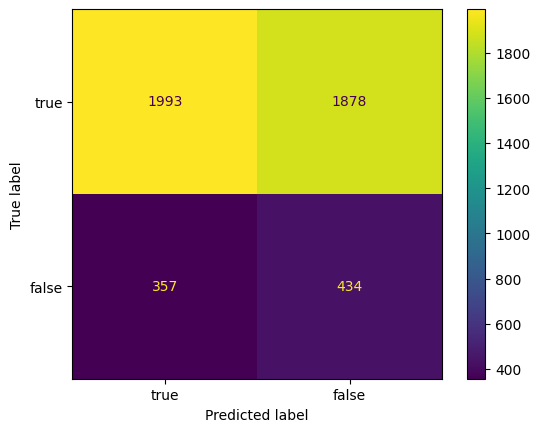

(52.06, 46.02)

In [117]:
p = predict_points(indiv_models, "weibo_categories.json", twitter_val)
check_score(p[0], weibo['target'])

In [95]:
m = train_models("pheme", pheme, 0.2, 200, model_list_3)


Trained models on Sensitive Subjects, added Random Forest to list
Trained models on News, added SVC to list
Trained models on Arts & Entertainment, added SVC to list
Trained models on People & Society, added KNN to list
Trained models on Law & Government, added SVC to list
Trained models on Online Communities, added KNN to list
Skipped category: Books & Literature due to low numbers
Skipped category: Reference due to low numbers
Skipped category: Jobs & Education due to low numbers
Skipped category: Health due to low numbers
Skipped category: Business & Industrial due to low numbers
Skipped category: Autos & Vehicles due to low numbers
Skipped category: Food & Drink due to low numbers
Trained models on Travel & Transportation, added SVC to list
Skipped category: Hobbies & Leisure due to low numbers
Skipped category: Games due to low numbers
Skipped category: Pets & Animals due to low numbers
Skipped category: Sports due to low numbers
Skipped category: Beauty & Fitness due to low numbe

In [110]:
p = predict_points(m, "pheme_categories.json", X_val)

  0%|          | 0/1285 [00:00<?, ?it/s]

100%|██████████| 1285/1285 [04:19<00:00,  4.94it/s]


R


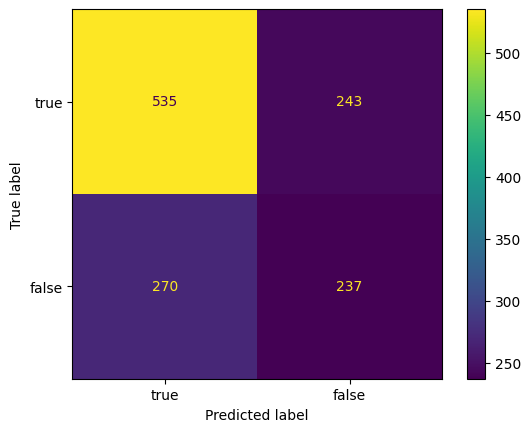

(60.08, 57.81)

In [111]:
check_score(p[0], y_val)

In [27]:
models1, results1 = run_tests(tests, 0.2, 200, model_list)

  0%|          | 0/3 [00:00<?, ?it/s]

Trained models on Sensitive Subjects, added KNN to list
Trained models on News, added Random Forest to list
Trained models on Arts & Entertainment, added SVM to list
Trained models on People & Society, added KNN to list
Trained models on Law & Government, added MLP to list
Trained models on Online Communities, added KNN to list
Skipped category: Books & Literature due to low numbers
Skipped category: Reference due to low numbers
Skipped category: Jobs & Education due to low numbers
Skipped category: Health due to low numbers
Skipped category: Business & Industrial due to low numbers
Skipped category: Autos & Vehicles due to low numbers
Skipped category: Food & Drink due to low numbers
Trained models on Travel & Transportation, added MLP to list
Skipped category: Hobbies & Leisure due to low numbers
Skipped category: Games due to low numbers
Skipped category: Pets & Animals due to low numbers
Skipped category: Sports due to low numbers
Skipped category: Beauty & Fitness due to low numbe

 33%|███▎      | 1/3 [04:02<08:04, 242.28s/it]

Trained models on People & Society, added KNN to list
Trained models on Arts & Entertainment, added MLP to list
Trained models on Law & Government, added SVM to list
Trained models on News, added SVM to list
Skipped category: Food & Drink due to low numbers
Trained models on Sensitive Subjects, added MLP to list
Trained models on Online Communities, added Random Forest to list
Skipped category: Internet & Telecom due to low numbers
Skipped category: Computers & Electronics due to low numbers
Skipped category: Health due to low numbers
Skipped category: Pets & Animals due to low numbers
Skipped category: Reference due to low numbers
Skipped category: Adult due to low numbers
Skipped category: Business & Industrial due to low numbers
Skipped category: Books & Literature due to low numbers
Skipped category: Jobs & Education due to low numbers
Skipped category: Shopping due to low numbers
Skipped category: Beauty & Fitness due to low numbers
Skipped category: Autos & Vehicles due to low nu

 67%|██████▋   | 2/3 [06:24<03:03, 183.18s/it]

Trained models on Arts & Entertainment, added SVM to list
Trained models on People & Society, added SVM to list
Skipped category: Reference due to low numbers
Trained models on Food & Drink, added KNN to list
Skipped category: Sports due to low numbers
Skipped category: Games due to low numbers
Skipped category: Travel & Transportation due to low numbers
Trained models on Health, added SGD to list
Skipped category: Online Communities due to low numbers
Trained models on News, added MLP to list
Skipped category: Science due to low numbers
Trained models on Sensitive Subjects, added SVM to list
Skipped category: Shopping due to low numbers
Skipped category: Finance due to low numbers
Skipped category: Real Estate due to low numbers
Skipped category: Jobs & Education due to low numbers
Trained models on Law & Government, added SVM to list
Skipped category: Business & Industrial due to low numbers
Skipped category: Computers & Electronics due to low numbers
Skipped category: Internet & Tel

100%|██████████| 3/3 [06:58<00:00, 139.54s/it]


In [81]:
results1

[('PHEME',
  [('PHEME', (61.17, 59.29)),
   ('twitterFULL', (52.95, 51.64)),
   ('WEIBO', (49.66, 34.6))]),
 ('twitterFULL',
  [('twitterFULL', (60.82, 60.67)),
   ('PHEME', (50.86, 50.19)),
   ('WEIBO', (52.57, 52.49))]),
 ('WEIBO',
  [('WEIBO', (63.77, 63.58)),
   ('PHEME', (47.13, 44.72)),
   ('twitterFULL', (49.7, 49.44))])]

In [51]:
X = weibo.drop("target", axis=1)
y = weibo["target"]
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.8, stratify=y) 
X_train_text = np.array([text for text in X_train['e_text']])
X_val_text = np.array([text for text in X_val['e_text']])

In [204]:
pheme_val = pheme.drop('target', axis=1)
pheme_val_text = np.array([text for text in pheme_val['e_text']])
twitter_val = twitter.drop('target', axis=1)
twitter_val_text = np.array([text for text in twitter_val['e_text']])
weibo_val = weibo.drop('target', axis=1)
weibo_val_text = np.array([text for text in weibo_val['e_text']])

In [212]:
from sklearn.ensemble import VotingClassifier
from deslib.des.knora_e import KNORAE

dataset = weibo

X = dataset.drop("target", axis=1)
y = dataset["target"]
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.8, stratify=y) 
X_train_text = np.array([text for text in X_train['e_text']])
X_val_text = np.array([text for text in X_val['e_text']])

vc = VotingClassifier(estimators = baseline_models, voting='hard')
vc.fit(X_train_text, y_train)
pred = vc.predict(X_val_text)
s = check_score(y_val, pred)
pheme_pred = vc.predict(pheme_val_text)
twitter_pred = vc.predict(twitter_val_text)
weibo_pred = vc.predict(weibo_val_text)
print(s)
print("PHEME:", check_score(pheme_pred, pheme['target']))
print("Twitter:", check_score(twitter_pred, twitter['target']))
print("Weibo:", check_score(weibo_pred, weibo['target']))

knora_models = []

for model_name, model in baseline_models:
    model.fit(X_train_text, y_train)
    knora_models.append(model)

knorae = KNORAE(knora_models)
knorae.fit(X_train_text, y_train)
pred = knorae.predict(X_val_text)
s = check_score(y_val, pred)
pheme_pred = knorae.predict(pheme_val_text)
twitter_pred = knorae.predict(twitter_val_text)
weibo_pred = knorae.predict(weibo_val_text)
print(s)
print("PHEME:", check_score(pheme_pred, pheme['target']))
print("Twitter:", check_score(twitter_pred, twitter['target']))
print("Weibo:", check_score(weibo_pred, weibo['target']))


(83.39, 83.38)
PHEME: (56.78, 50.99)
Twitter: (51.6, 50.0)
Weibo: (93.93, 93.93)
(83.39, 83.33)
PHEME: (56.17, 48.23)
Twitter: (50.48, 46.08)
Weibo: (96.68, 96.67)


In [74]:
diff = []
for i in range(len(p[0])):
    if p[0][i] != pred[i]:
        print(p[0][i], pred[0])
        diff.append(i)

True False
True False
True False
True False
True False
False False
True False
False False
True False
False False
True False
True False
False False
True False
True False
True False
True False
False False
False False
True False
True False
False False
True False
True False
False False
False False
True False
False False
False False
True False
True False
False False
True False
True False
True False
True False
True False
False False
False False
False False
False False
False False
True False
True False
False False
True False
False False
True False
True False
True False
True False
False False
False False
True False
True False
False False
True False
True False
True False
True False
True False
True False
True False
True False
True False
True False
True False
True False
False False
True False
True False
False False
False False
True False
False False
True False
False False
False False
True False
True False
True False
True False
True False
True False
True False
True False
True False
True False
Fals

In [75]:
len(diff)

417

In [79]:
n = 1
m = diff[n]
m

13

In [80]:
print(pred[m], p[0][m], y_val.iloc[m], p[1][m])

False True False [(True, 0.8362255965292842, 'SVM', 'Sensitive Subjects'), (True, 0.8277886497064579, 'SVM', 'News'), (True, 0.8848167539267016, 'SVM', 'People & Society'), (True, 0.8862559241706162, 'KNN', 'Arts & Entertainment')]
